In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!pip install import-ipynb

In [ ]:
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import numpy as np
import shutil
import string
import tensorflow as tf
import import_ipynb

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

Can update to use my own dataset but it cannot read the URL from my drive

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file('aclImdb_v1', url, untar = True, cache_dir= '.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 7s 0us/step


In [ ]:
os.listdir(dataset_dir)

['README', 'imdb.vocab', 'test', 'imdbEr.txt', 'train']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'urls_unsup.txt',
 'unsupBow.feat',
 'unsup',
 'urls_pos.txt',
 'neg',
 'labeledBow.feat',
 'pos']

loading in the dataset from file. For this we need two folders for binary classification

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


text is in: text, label(positive(1), negative(0))


In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


Below is standardize, tokenize, vectorize data

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', '')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [ ]:
max_feature = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_feature,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [ ]:
#text dataset
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review ", first_review)
print("Label ", raw_train_ds.class_names[first_label])
print("Vectorized review ", vectorize_text(first_review, first_label))

Review  tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />

In [ ]:
print("313 ->", vectorize_layer.get_vocabulary()[313])

313 -> audience


In [ ]:
train_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
    layers.Embedding(max_feature+1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=tf.metrics.BinaryAccuracy(threshold = 0.0))

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
782/782 [==============================] - 9s 11ms/step - loss: 0.6532 - binary_accuracy: 0.7062 - val_loss: 0.5902 - val_binary_accuracy: 0.7756
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.5134 - binary_accuracy: 0.8157 - val_loss: 0.4675 - val_binary_accuracy: 0.8296
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.4089 - binary_accuracy: 0.8561 - val_loss: 0.4002 - val_binary_accuracy: 0.8458
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3481 - binary_accuracy: 0.8746 - val_loss: 0.3651 - val_binary_accuracy: 0.8540
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3100 - binary_accuracy: 0.8866 - val_loss: 0.3453 - val_binary_accuracy: 0.8624
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.2828 - binary_accuracy: 0.8959 - val_loss: 0.3337 - val_binary_accuracy: 0.8630
Epoch 7/10
782/782 [==============================] - 4s 5ms/st

Evaluating Model for Accuracy


In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 6s 7ms/step - loss: 0.2015 - binary_accuracy: 0.9275
Loss:  0.2015070915222168
Accuracy:  0.9275199770927429


Plotting Model

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

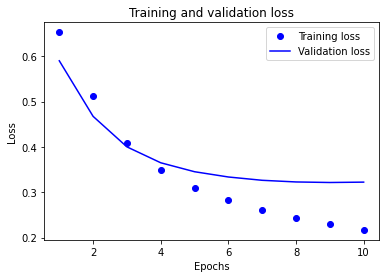

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Create new model for Reddit with weights already trained

In [ ]:
export_model = tf.keras.Sequential([
      vectorize_layer,
      model,
      layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.2015 - accuracy: 0.9275
0.9275199770927429


In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **START OF REDDIT CRAWLER**

In [ ]:
!pip install praw

     |████████████████████████████████| 174kB 13.0MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 


In [ ]:
import praw
from prawcore import NotFound
import io
from praw.models import MoreComments



In [ ]:
reddit = praw.Reddit(client_id='...', 
                    client_secret='...', 
                    user_agent='...', check_for_async = False)


NameError: ignored

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = '/content/drive/MyDrive/personal_projects/Reddit/list_of_subreddits.csv'
#empty dict with subreddit:posts values
posts = {}

In [ ]:
subs = pd.read_csv(link)
print(subs)

            Subreddit  ...                                        Description
0             Finance  ...  Welcome to r/Finance!\n\nNo Personal Finance, ...
1              Stocks  ...  Almost any post related to stocks is welcome o...
2             Bitcoin  ...  A community dedicated to Bitcoin, the currency...
3    SecurityAnalysis  ...                        Welcome to SecurityAnalysis
4   Wallstreetbetsnew  ...           This is the public Wall Street Bets Sub!
..                ...  ...                                                ...
59     Cryptocurrency  ...  The leading community for cryptocurrency news,...
60        UKInvesting  ...  Welcome to /r/UKInvesting, a subreddit for tho...
61          ausstocks  ...  A place for Australians to discuss securities ...
62     WallStreetBets  ...              Like 4chan found a Bloomberg Terminal
63          dividends  ...  A community by and for dividend growth investo...

[64 rows x 3 columns]


In [ ]:

sub_list = subs['Subreddit'].tolist()
print(sub_list)

['Finance', 'Stocks', 'Bitcoin', 'SecurityAnalysis', 'Wallstreetbetsnew', 'StocksAndTrading', 'PennystocksDD', 'PennyStocks', 'algotrading', 'babystreetbets', 'Economics', 'ASX_Bets', 'antstreetbets', 'quant', 'weedstocks', 'investing', 'Economy', 'shortinterestbets', 'thetagang', 'Pennystocks', 'InvestingRetards', 'wallstreetbet', 'wallstreetbetsoptions', 'econmonitor', 'Wallstreetwarrior', 'StockMarket', 'Dividends', 'wallstreetbets2', 'Trading', 'WSBAfterHours', 'smallstreetbets', 'retardbets', 'finance', 'InvestmentClub', 'stocks', 'IndianStreetBets', 'wallstreetsidebets', 'Stock_Picks', 'baystreetbets', 'ameisenstrassenwetten', 'wallstreetbets_', 'ISKbets', 'quantfinance', 'stonks', 'GlobalMarkets', 'Investing', 'Daytrading', 'WallStreetbetsELITE', 'RobinHoodPennyStocks', 'DayTrading', 'CanadianInvestor', 'pennystocks', 'Options', 'AlgoTrading', 'MoonBets', 'algorithmictrading', 'farialimabets', 'Wallstreetsilver', 'wallstreetbets', 'Cryptocurrency', 'UKInvesting', 'ausstocks', 'W

Made dictionary 'posts' with <sub,posts> values to keep data organized if extraction is wanted

---



In [ ]:

#dict to organize posts
for subs in sub_list:
  posts[subs] = None

print(posts)

{'Finance': None, 'Stocks': None, 'Bitcoin': None, 'SecurityAnalysis': None, 'Wallstreetbetsnew': None, 'StocksAndTrading': None, 'PennystocksDD': None, 'PennyStocks': None, 'algotrading': None, 'babystreetbets': None, 'Economics': None, 'ASX_Bets': None, 'antstreetbets': None, 'quant': None, 'weedstocks': None, 'investing': None, 'Economy': None, 'shortinterestbets': None, 'thetagang': None, 'Pennystocks': None, 'InvestingRetards': None, 'wallstreetbet': None, 'wallstreetbetsoptions': None, 'econmonitor': None, 'Wallstreetwarrior': None, 'StockMarket': None, 'Dividends': None, 'wallstreetbets2': None, 'Trading': None, 'WSBAfterHours': None, 'smallstreetbets': None, 'retardbets': None, 'finance': None, 'InvestmentClub': None, 'stocks': None, 'IndianStreetBets': None, 'wallstreetsidebets': None, 'Stock_Picks': None, 'baystreetbets': None, 'ameisenstrassenwetten': None, 'wallstreetbets_': None, 'ISKbets': None, 'quantfinance': None, 'stonks': None, 'GlobalMarkets': None, 'Investing': Non

In [ ]:
def sub_exists(sub):
    exists = True
    try:
        reddit.subreddits.search_by_name(sub, exact=True)
    except NotFound:
        exists = False
    return exists

In [ ]:
import re
def comments(urlT):
  candice = []

  try:
    check = reddit.submission(url = urlT)
    sub_comments = check.comments
    sub_comments.comment_sort = 'best'
    sub_comments.comment_limit = 15
  except:
    return ""

  for c in sub_comments:
    try:
      candice.append(c.body)
    except:
      return ''

  return candice

In [ ]:
def getRedditPosts(sub_list):
  for sub in sub_list:
    for submissions in reddit.subreddit(sub).hot(limit = 10):
      posts[sub] = comments(submissions.url)

In [ ]:
getRedditPosts(sub_list)

In [ ]:
 print(posts)

{'Finance': '', 'Stocks': '', 'Bitcoin': '', 'SecurityAnalysis': '', 'Wallstreetbetsnew': '', 'StocksAndTrading': [], 'PennystocksDD': ['With the bitcoin practicing skydiving, bitcoin stocks are going nowhere'], 'PennyStocks': ['\nDoes this submission fit our subreddit? If it does please **upvote** this comment. If it does not fit the subreddit please **downvote** this comment.\n\n\n\n---\n\n^(*I am a bot, and this comment was made automatically.*) ^(Please) [^(contact)^( )^(us)^( )^(via)^( )^(modmail)](https://www.reddit.com/message/compose?to=/r/pennystocks&subject=Updoot%20bot%20questions!) \n^(if) ^(you) ^(have) ^(any) ^(questions) ^(or) ^(concerns.)', "There's decent short term potential on this simply based on the rise of LWLG over the last few weeks. Similar industry/tech.", 'Pardon my lack of knowledge/research, but does anyone happen to know how much correlation, if any, this company has with Lightwave Logic? Both have moved nicely in recent sessions. Thanks in advance!'], 'al

Normalize data in dictionary and ready for NN processing
Emojis, lowercases, punctuations, html, links

In [ ]:
import re, string, unicodedata
import nltk
import inflect
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [ ]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", '', str(sample))

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        new_word = re.sub(r'\n', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [ ]:
#lists of slang

reddit_ = [
                  'hodl',
                  'HODL',
                  'citron',  
                  'hidenburg',        
                  'moon',
                  'highs',
                  'mooning',
                  'long',
                  'short',
                  'call',
                  'calls',    
                  'put',
                  'puts',    
                  'break',
                  'tendie',
                  'tendies',
                  'town',     
                  'overvalued',
                  'undervalued',
                  'buy',
                  'sell',
                  'gone',
                  'gtfo',
                  'paper',
                  'bullish',
                  'bearish',
                  'bagholder',
                  'stonk',
                  'green',
                  'money',
                  'print',
                  'rocket',
                  'bull',
                  'bear',
                  'pumping',
                  'sus',
                  'offering',
                  'rip',
                  'downgrade',
                  'upgrade',     
                  'maintain',          
                  'pump',
                  'hot',
                  'drop',
                  'rebound',  
                  'crack'
              ]

In [ ]:
def normalize(posts):
  for key in list(posts):
      if posts[key] == [] or 'bot' in posts[key] :
        posts.pop(key)
        continue

      posts[key] = remove_non_ascii(posts[key])
      posts[key] = to_lowercase(posts[key])
      posts[key] = remove_punctuation(posts[key])
      posts[key] = replace_numbers(posts[key])
      posts[key] = remove_URL(posts[key])


In [ ]:
#put data into csv to see it
normalize(posts)
for key, value in posts.items():
    print(key, ' : ', value)

PennystocksDD  :  ['with the bitcoin practicing skydiving, bitcoin stocks are going nowhere']
PennyStocks  :  ['does this submission fit our subreddit? if it does please **upvote** this comment. if it does not fit the subreddit please **downvote** this comment.---^(*i am a bot, and this comment was made automatically.*) ^(please) [^(contact)^( )^(us)^( )^(via)^( )^(modmail)]( ^(if) ^(you) ^(have) ^(any) ^(questions) ^(or) ^(concerns.)', "there's decent short term potential on this simply based on the rise of lwlg over the last few weeks. similar industry/tech.", 'pardon my lack of knowledge/research, but does anyone happen to know how much correlation, if any, this company has with lightwave logic? both have moved nicely in recent sessions. thanks in advance!']
algotrading  :  ['i found ib_insync the easiest to get started with and should do what you need.', 'a lot of people on this sub and related subs, including me, use ib_insync, programmed by ewald de wit. it is popular because it 

In [ ]:
def data():
  return list(posts.values())

In [ ]:
x = data()

# **END OF REDDIT SCRAPER AND DATA IS GATHERED **bold text**
**

In [ ]:
flat_list = [item for sublist in x for item in sublist]

In [ ]:
model = export_model.predict(flat_list)

In [ ]:
#interpret if the numbers [0,1] mean bullish or bearish
bull = 0
bear = 0

for x in model:
  if x < .5:
    bear = bear + 1
  else:
    bull = bull + 1

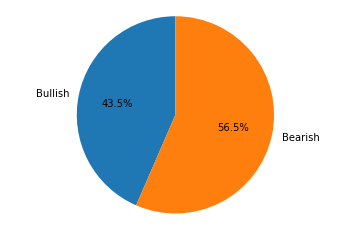

In [ ]:
labels = 'Bullish', 'Bearish'
sizes = [bull, bear]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()